# Hot Water Consumption Forecasting Model And SHAP Values

---

In this notebook, we are going to use SHAP values to explain our best model's hot water consumption predictions on the testing dataset.

As always, the prerequisite step consists on loading the appropriate packages to perform our work:

In [1]:
# Needed packages:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import shap
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from utils import create_illustration_sample, create_training_testing_datasets, calculate_rmsle

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


In [2]:
# Print the JS visualization code to the notebook:
shap.initjs()

---

## Step 1: Load model and check results

In [3]:
# Load the data:
hot_water = pd.read_csv("../data/dataset_hot_water.csv")

# Check basic info:
print("*** Some basic info:")
print("'dataset_hot_water' has {} data points with {} variables each.".format(*hot_water.shape))
print("'dataset_hot_water' counts {} missing values.".format(hot_water.isnull().sum().sum()))

# Give a look to the first lines:
print("\n*** First lines:")
display(hot_water.head(n=5))

*** Some basic info:
'dataset_hot_water' has 791788 data points with 39 variables each.
'dataset_hot_water' counts 0 missing values.

*** First lines:


,building_id,meter,timestamp,meter_reading,site_id,square_feet,air_temperature,dew_temperature,wind_speed,hour,...,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage
0,112,3,2016-01-01 00:00:00,96.9780,1,-0.763830,-1.128203,-0.536276,-0.127438,0,...,0,0,0,0,0,0,0,0,0,0
1,113,3,2016-01-01 00:00:00,19.5970,1,0.208396,-1.128203,-0.536276,-0.127438,0,...,0,0,0,0,0,0,0,0,0,0
2,114,3,2016-01-01 00:00:00,100.0000,1,0.766627,-1.128203,-0.536276,-0.127438,0,...,0,0,0,0,0,0,0,0,0,0
3,117,3,2016-01-01 00:00:00,19.6809,1,-1.001878,-1.128203,-0.536276,-0.127438,0,...,0,0,0,0,0,0,0,0,0,0
4,119,3,2016-01-01 00:00:00,200.0000,1,0.075510,-1.128203,-0.536276,-0.127438,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Create illustration sample to be consistent with what has been done previously:
hot_water_2, timestamp, y_sample, X_sample = create_illustration_sample(hot_water, 1325)

# Create training and testing datasets:
X_train, X_test, y_train, y_test = create_training_testing_datasets(hot_water_2)

In [5]:
# Load hot water consumption forecasting best model:
opt_xgb_reg = joblib.load("../models/opt_xgb_reg_hot_water.pkl")

In [6]:
# Check model:
y_pred_xgb_train = opt_xgb_reg.predict(X_train)
rmsle_xgb_train = calculate_rmsle(y_train, y_pred_xgb_train)
y_pred_xgb_test = opt_xgb_reg.predict(X_test)
rmsle_xgb_test = calculate_rmsle(y_test, y_pred_xgb_test)
print("*** Hot water consumption forecasting best model results:")
print("RMSLE on training dataset: {:.6f}".format(rmsle_xgb_train))
print("RMSLE on testing dataset: {:.6f}".format(rmsle_xgb_test))

*** Hot water consumption forecasting best model results:
RMSLE on training dataset: 0.850988
RMSLE on testing dataset: 0.881483


Fast checking is OK!

---

## Step 2: Explain model with SHAP values

In [7]:
# Build DataFrame from testing dataset:

# Generate column labels:
labels_to_drop = ['building_id',
                  'meter',
                  'timestamp',
                  'meter_reading',
                  'site_id',
                  'hour',
                  'weekday',
                  'week',
                  'month']
X_test_hd = [label for label in hot_water.columns.values.tolist() if label not in labels_to_drop]

# Consolidate DataFrames:
X_test_df = pd.DataFrame(X_test)
X_test_df.columns = X_test_hd

In [8]:
# Compute the SHAP values for every prediction in the testing dataset:
explainer = shap.TreeExplainer(opt_xgb_reg)
shap_values = explainer.shap_values(X_test_df, check_additivity=False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


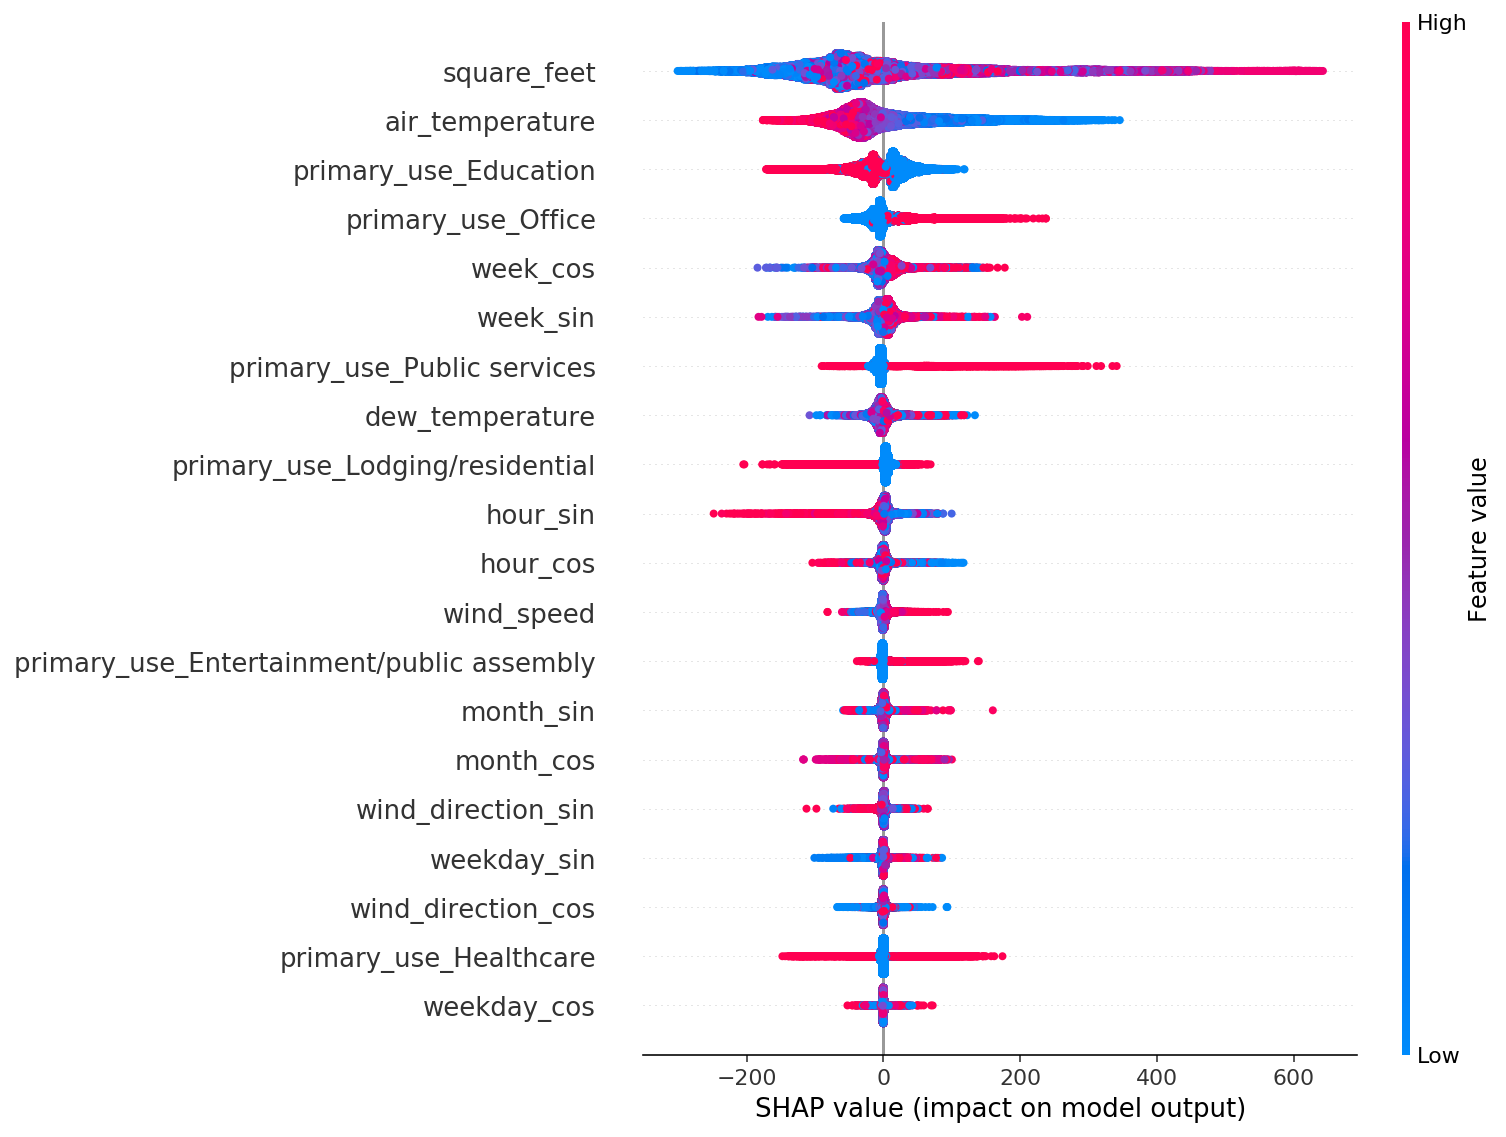

In [9]:
# Summarize the effects of all the features and generate summary plot:
fig, ax = plt.subplots(figsize=(8, 5))
ax = shap.summary_plot(shap_values, X_test_df)
fig.savefig('../graphs/shap_values_summary_plot_hot_water.png', bbox_inches='tight')

Above, thanks to SHAP values, we can observe what features drive the predictions on the testing dataset of our hot water consumption forecasting best model. Thus, if we consider the "top 5" features, by order of importance, we have:
* Surface of the building,
* Air temperature,
* Education as primary use,
* Office as primary use,
* Week's position in the year.

So, for example, analyzing the two most important features, in accordance with what was intuitively expected, we can note that the highest the building's surface is, the more hot water consumption will be, and, the hotest the air temperature is, the less hot water consumption will be. It is interesting to note, too, that building's primary use (espacially education, office, public services and healthcare) seems to have disruptive impact.